In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Rutas completas
TRAIN_PATH = r"C:\Users\maria\OneDrive\Documentos\AnotherSigma\PONTIA\PROYECTO JUPITER\archive\train"
TEST_PATH = r"C:\Users\maria\OneDrive\Documentos\AnotherSigma\PONTIA\PROYECTO JUPITER\archive\test"
BASE_PATH = r"C:\Users\maria\OneDrive\Documentos\AnotherSigma\PONTIA\PROYECTO JUPITER\archive"

In [ ]:
# Definir las dimensiones de las imágenes (MobileNetV2 espera 224x224)
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

In [ ]:
# Definir las clases (emociones en inglés)
CLASSES = ['surprise', 'happy', 'neutral', 'angry', 'fear', 'sad', 'disgust']

In [ ]:
# Crear generadores de datos con aumentación para el conjunto de entrenamiento
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)


In [ ]:
# Generador para el conjunto de entrenamiento
train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=CLASSES,
    subset='training',
    shuffle=True
)


Found 22968 images belonging to 7 classes.


In [ ]:
# Generador para el conjunto de validación
validation_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=CLASSES,
    subset='validation',
    shuffle=False
)

Found 5741 images belonging to 7 classes.


In [ ]:
# Generador para el conjunto de prueba (sin aumentación)
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=CLASSES,
    shuffle=False
)

Found 7178 images belonging to 7 classes.


In [ ]:
# Obtener el número de clases y el mapeo de clases
num_classes = len(CLASSES)
class_indices = train_generator.class_indices
print("Número de clases:", num_classes)
print("Clases:", class_indices)

Número de clases: 7
Clases: {'surprise': 0, 'happy': 1, 'neutral': 2, 'angry': 3, 'fear': 4, 'sad': 5, 'disgust': 6}


In [ ]:
# Calcular pesos de clase con Scikit-learn
train_labels = train_generator.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights_dict = dict(enumerate(class_weights))
print("Pesos de clase:", class_weights_dict)

Pesos de clase: {0: 1.2933160650937552, 1: 0.5684585684585685, 2: 0.826068191627104, 3: 1.0266404434114071, 4: 1.0009587727708533, 5: 0.8491570541259982, 6: 9.401555464592715}


In [ ]:
# Construir el modelo MobileNetV2 con Transfer Learning
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

In [ ]:
# Cargar MobileNetV2 preentrenado (sin la capa final)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

9406464/9406464 [==============================] - 2s 0us/step


In [ ]:
# Congelar las capas base para no entrenarlas
base_model.trainable = False

In [ ]:
# Añadir capas personalizadas para la clasificación
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

In [ ]:
# Crear el modelo final
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Resumen del modelo
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [ ]:
# Entrenar el modelo
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint(os.path.join(BASE_PATH, 'best_model.h5'), monitor='val_accuracy', save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, mode='max')

history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    class_weight=class_weights_dict,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/20
718/718 [==============================] - 758s 1s/step - loss: 1.7406 - accuracy: 0.2876 - val_loss: 1.7540 - val_accuracy: 0.3048
Epoch 2/20
718/718 [==============================] - 835s 1s/step - loss: 1.7422 - accuracy: 0.2888 - val_loss: 1.7549 - val_accuracy: 0.2911
Epoch 3/20
718/718 [==============================] - 775s 1s/step - loss: 1.7286 - accuracy: 0.2870 - val_loss: 1.6936 - val_accuracy: 0.3637
Epoch 4/20
718/718 [==============================] - 782s 1s/step - loss: 1.7304 - accuracy: 0.2889 - val_loss: 1.6858 - val_accuracy: 0.3517
Epoch 5/20
718/718 [==============================] - 805s 1s/step - loss: 1.7305 - accuracy: 0.2877 - val_loss: 1.7161 - val_accuracy: 0.3322
Epoch 6/20
718/718 [==============================] - 757s 1s/step - loss: 1.7379 - accuracy: 0.2878 - val_loss: 1.6942 - val_accuracy: 0.3456
Epoch 7/20
718/718 [==============================] - 731s 1s/step - loss: 1.7325 - accuracy: 0.2919 - val_loss: 1.6818 - val_accuracy: 0.3526

In [ ]:
# Cargar el mejor modelo guardado
model.load_weights(os.path.join(BASE_PATH, 'best_model.h5'))

In [ ]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

225/225 [==============================] - 109s 479ms/step - loss: 1.6073 - accuracy: 0.4078
Test Loss: 1.6073
Test Accuracy: 0.4078


In [ ]:
# Obtener predicciones y etiquetas reales
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

225/225 [==============================] - 118s 526ms/step


In [ ]:
# Calcular métricas con Scikit-learn
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=CLASSES))

Classification Report:
              precision    recall  f1-score   support

    surprise       0.44      0.71      0.54       831
       happy       0.61      0.63      0.62      1774
     neutral       0.33      0.47      0.39      1233
       angry       0.23      0.07      0.10       958
        fear       0.21      0.08      0.11      1024
         sad       0.34      0.39      0.36      1247
     disgust       0.13      0.23      0.17       111

    accuracy                           0.41      7178
   macro avg       0.33      0.37      0.33      7178
weighted avg       0.38      0.41      0.38      7178



In [ ]:
# Calcular F1-score promedio
f1 = f1_score(y_true, y_pred_classes, average='weighted')
print(f"Weighted F1-Score: {f1:.4f}")

Weighted F1-Score: 0.3771


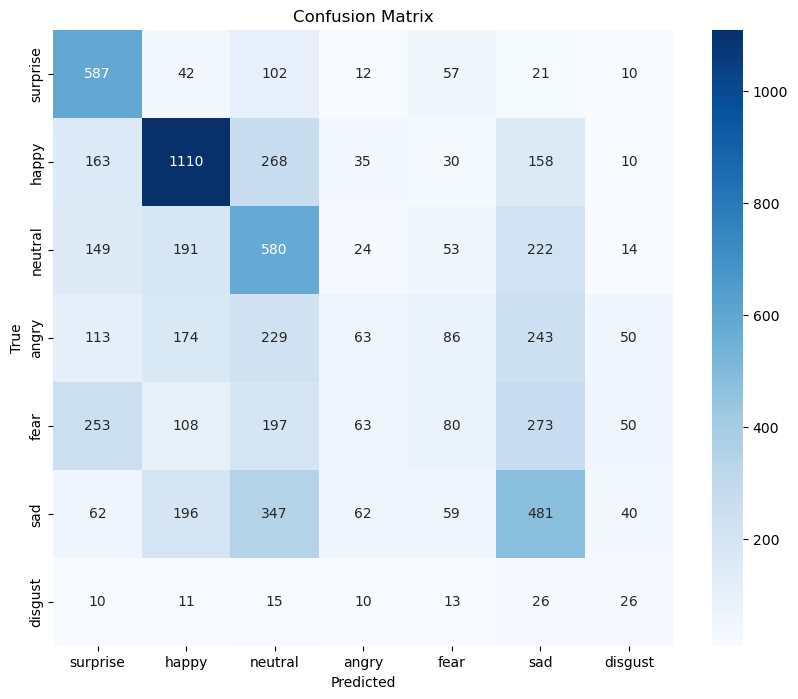

In [ ]:
# Crear y mostrar la matriz de confusión
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()